# Load datacube

In [1]:
# timestr used to create simple timestamps for easier version controll
import time
timestr = time.strftime("%Y%m%d")

# py4dstem as main tool, the follwing command also prints the currently used version
import py4DSTEM
from py4DSTEM import show
py4DSTEM.__version__

'0.14.15'

In [2]:
# Load the .dm4 file from a workspace on OMNI or XNAS, set filepath with 'filepath_data = "FILEPATH"'

dirpath = "/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/"

filepath_data = dirpath + 'COPL_Ni65Cu35_C_ROI3_240827_aper_50_conv_1.5_spot_6_CL_47_stepsize_10_r_x_178_r_y_186_GIF_512x512_preprocessed_unfiltered_no_bin.h5'

filepath_cif = dirpath + 'CuNi.cif'


In [3]:
# Load the datacubes using py4DSTEM

datacube = py4DSTEM.read(
    filepath = filepath_data,
    datapath = 'dm_dataset_root/dm_dataset'
)


datacube

DataCube( A 4-dimensional array of shape (186, 178, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0,5,10,...] nm
              Ry = [0,5,10,...] nm
              Qx = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
              Qy = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
)

# Virtual imaging

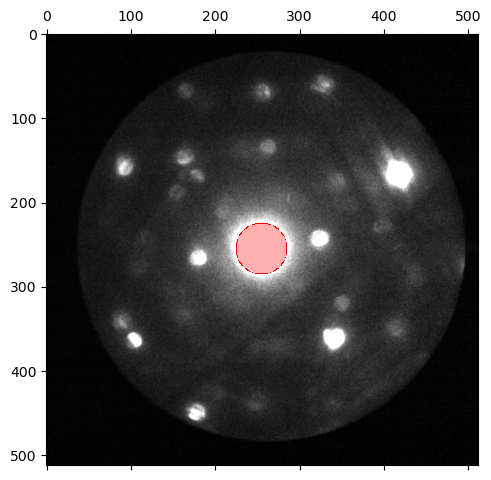

In [4]:
# First we need to position the detector
# we can set the geometry by hand

center = (255,255)

radius = 30


# overlay selected detector position over mean dp
datacube.position_detector(
    mode = 'circle',
    geometry = (
        center,
        radius
    )
)

100%|████████████████████████████████████████████████████████████████████████████████| 33108/33108 [00:05<00:00, 6263.54it/s]


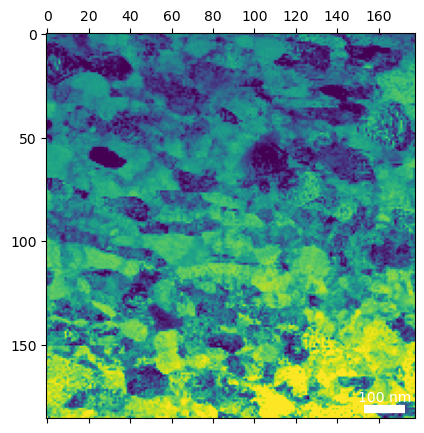

In [5]:
# Capture/compute the virtual BF 

datacube.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field',       # the output will be stored in `datacube`'s tree with this name
)

# and show the result
fig, ax = show( datacube.tree('bright_field'),
    returnfig = True,
        cmap='viridis'
              )


# Synthetic probe template

overflow encountered in exp


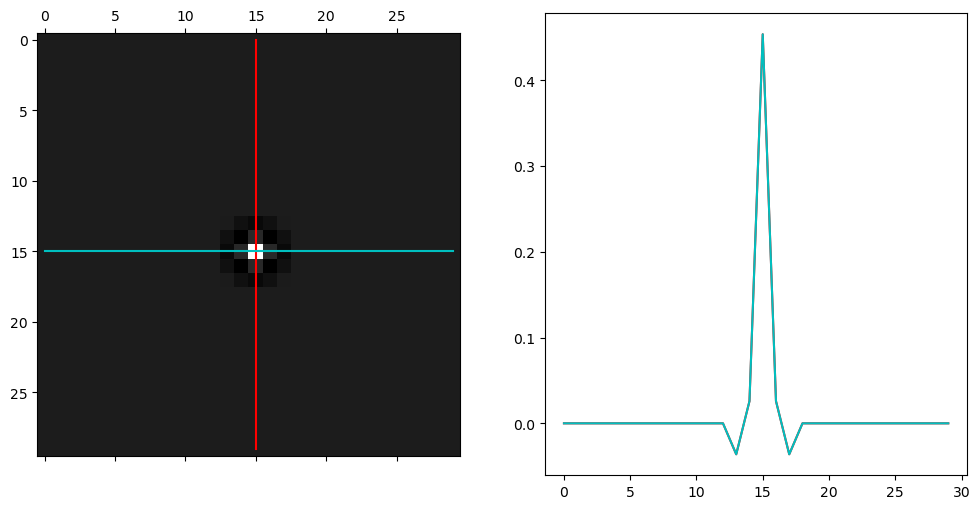

In [6]:
# define the semiangle
probe_semiangle = 0.75

# generate probe
probe = py4DSTEM.Probe.generate_synthetic_probe(
    radius = probe_semiangle,
    width = 0.7,
    Qshape = datacube.Qshape
)

probe.get_kernel(
    mode = 'sigmoid',
    origin = (datacube.Qshape[0]/2,datacube.Qshape[0]/2),
    radii = (probe_semiangle * 1.2,
             probe_semiangle * 4
    )
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 15,
    L = 15,
    W = 1
)

# Bragg disk detection

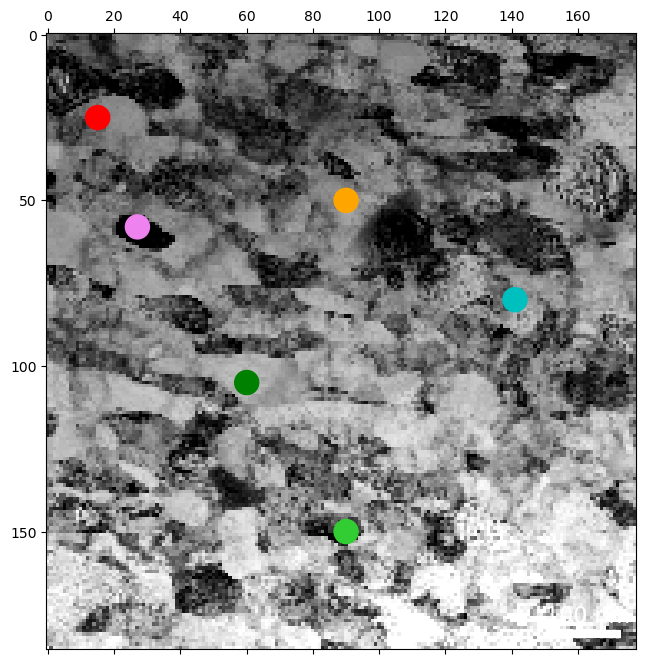

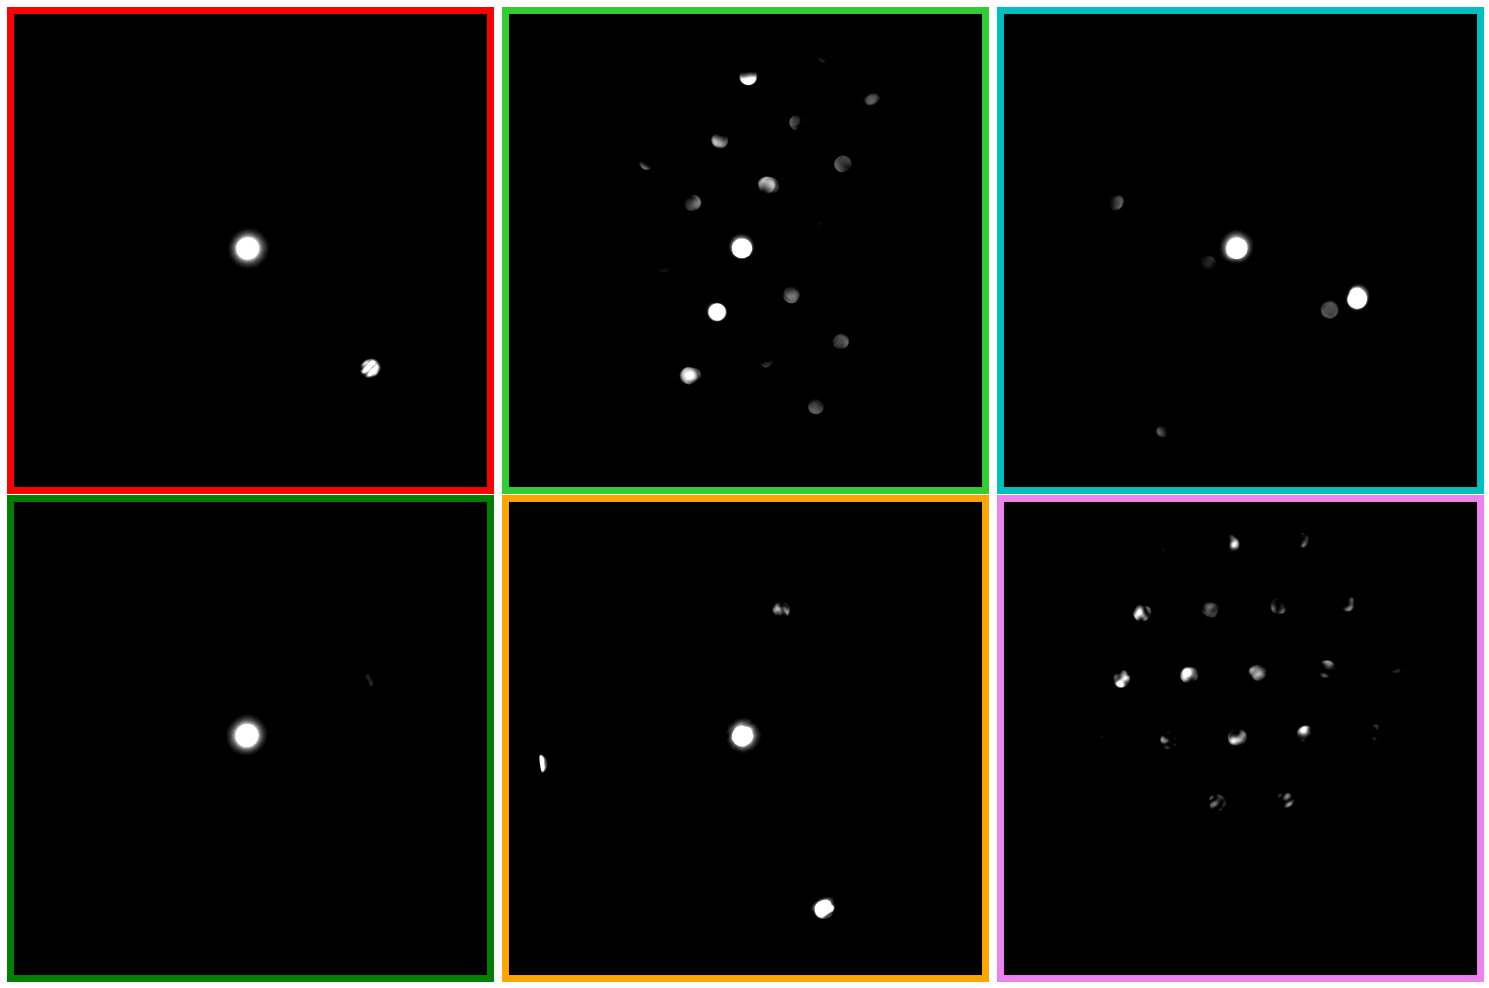

In [7]:
# Select a few sample patterns for parameter tuning

rxs = 25,150,80,105,50,58
rys = 15,90,141,60,90,27

colors=['r','limegreen','c','g','orange', 'violet']


# visualize

colors=['r','limegreen','c','g','orange', 'violet']

# show the selected
# positions in real space
fig, ax = py4DSTEM.visualize.show_points(
    datacube.tree('bright_field'),
    x=rxs,
    y=rys,
    scale=300,
    pointcolor=colors,
    figsize=(8,8),
    returnfig = True
)


# show the selected
# diffraction patterns
fig, ax = py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=2e4,
    vmax=1e5,
    scaling='power',
    power=0.75,
    get_bordercolor = lambda i:colors[i],
    returnfig = True
)


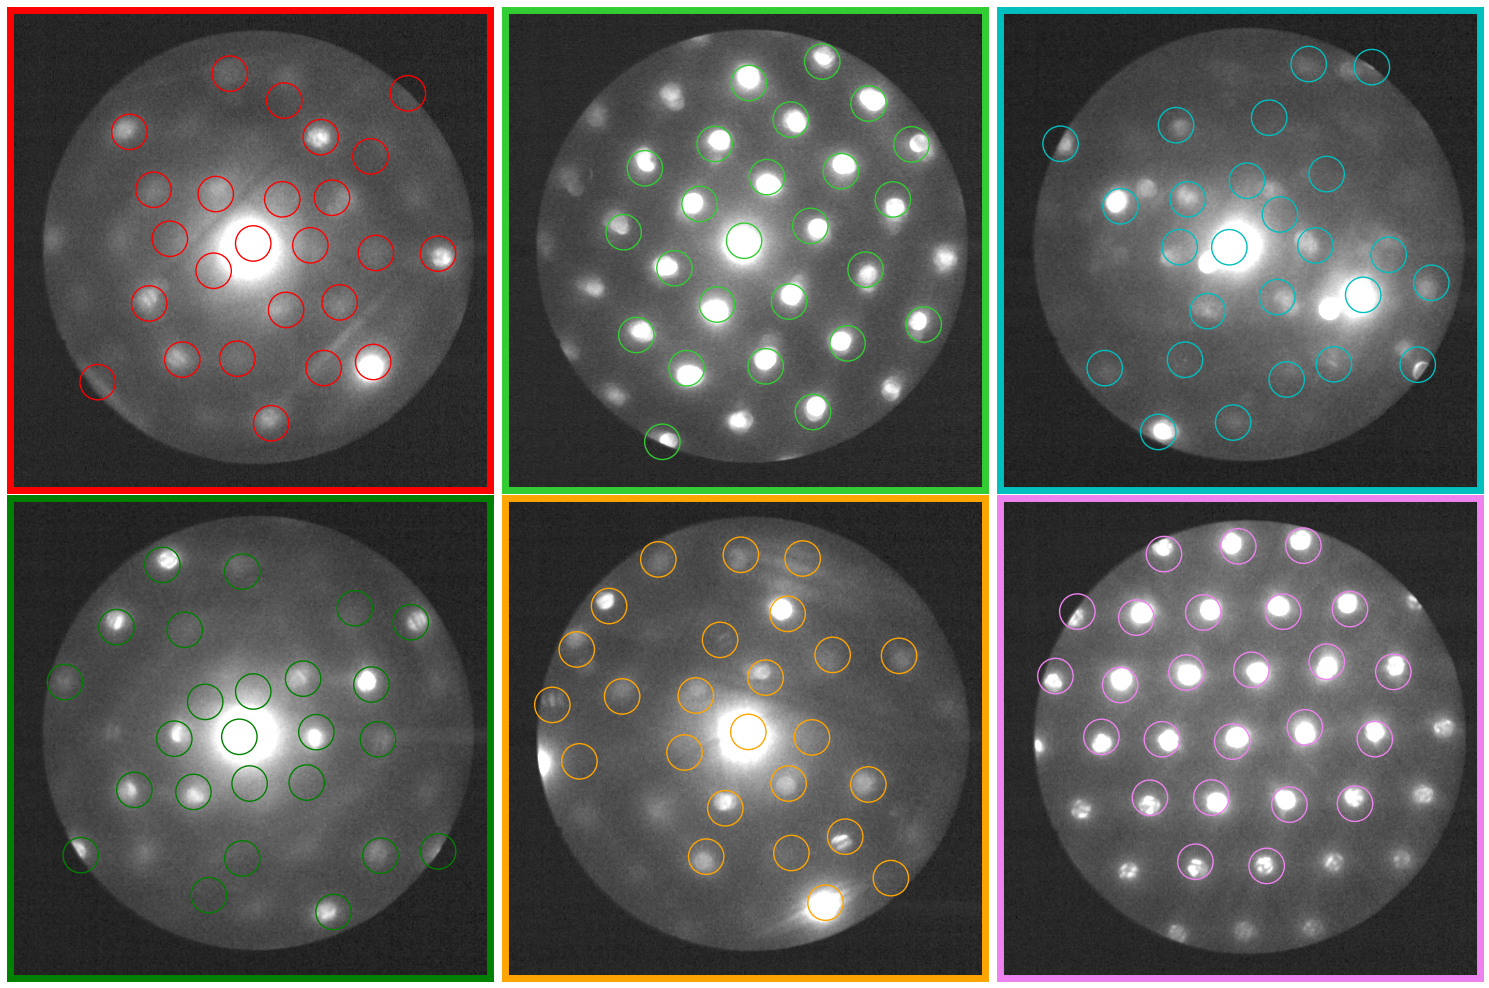

In [19]:
# Choose disk detection parameters

# set parameters

detect_params = {
    'minAbsoluteIntensity': 0,   # intensity threshold
    'minRelativeIntensity': 0,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 50,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 50,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 0.4,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 25,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'poly',         # subpixel resolution method
    'corrPower': 1,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
#     'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
}


# find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
fig, ax = py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 650,
    returnfig = True,
    vmin = 0,
    vmax = 1e4,
)


In [20]:
# Find Bragg peaks for all probe positions
bragg_peaks = datacube.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████████| 33.1k/33.1k [28:24<00:00, 19.4DP/s]


Localizing the disks measures the Bragg points.  Just like the max and mean diffraction patterns allow us to get a succinct but highly informative picture of the whole dataset all at once, it's useful to condense all the information about Bragg scattering we just measured into a single visualization.  We do this with a Bragg vector map - a 2D histogram of all the Bragg vector positions and intensities we've measured.

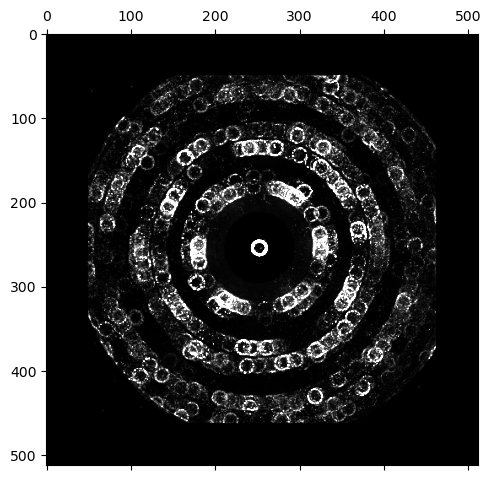

In [21]:
# Bragg vector map

# compute
bvm = bragg_peaks.histogram( mode='raw' )

# show
show(bvm)

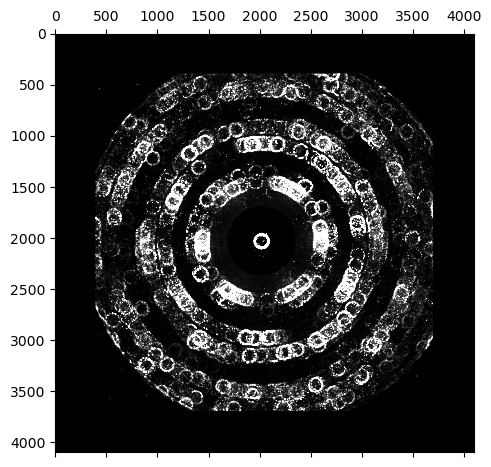

In [22]:
# Increasing the sampling can be helpful to visualize the resolution and error of our measurement.

# compute
bvm_upsampled = bragg_peaks.histogram(
    mode='raw',
    sampling = 8
)

# show
show(bvm_upsampled)

In [39]:
# set a filepath

filepath_save = dirpath + 'ACOM_HPT_ROI3_braggvectors.h5'
filepath_save

'/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/ACOM_HPT_ROI3_braggvectors.h5'

In [40]:
# inspect what's in `datacube`'s  tree

datacube.tree()

/
|---bright_field
|---braggvectors


In [41]:
# save everthing except the datacube

py4DSTEM.save(
    filepath_save,
    datacube,
    tree = None,  # everything *under* datacube, but not not datacube itself
    mode = 'o'
)

100%|████████████████████████████████████████████████████████████████████████████████| 33108/33108 [00:03<00:00, 9021.69it/s]


In [42]:
# inspect the resulting HDF5 file

py4DSTEM.print_h5_tree(filepath_save)

/
|---dm_dataset_root
    |---braggvectors
    |   |---_v_uncal
    |---bright_field




# Centering and calibration

## calibrate the origin

In [43]:
# All the calibrations are still set to False because we haven't performed
# any calibration measurements yet!

bragg_peaks.calstate

{'center': True, 'ellipse': True, 'pixel': True, 'rotate': False}

In [44]:
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.02685566
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_mean:           254.17369709345004
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           253.67134323278796
             qy0_shift:          2D-array
             a:                  nan
             b:                  nan
             theta:              -2.355398116633859
)

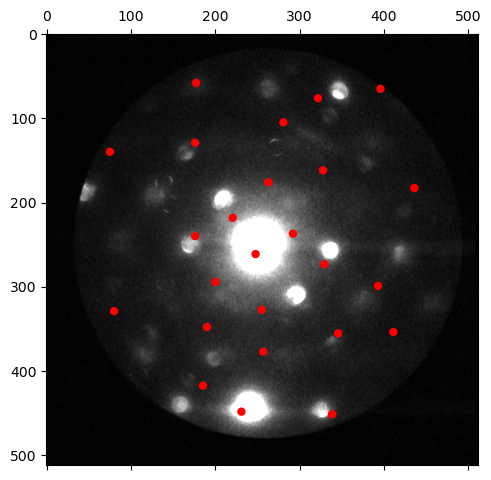

In [47]:
# Let's confirm that the raw vectors represent the positions of
# detected bragg disks in a sample diffraction pattern

dp = datacube[163,163]
v = bragg_peaks.raw[63,63]

show(
    dp,
    points = {
        'x' : v.qx,
        'y' : v.qy,
    }
)

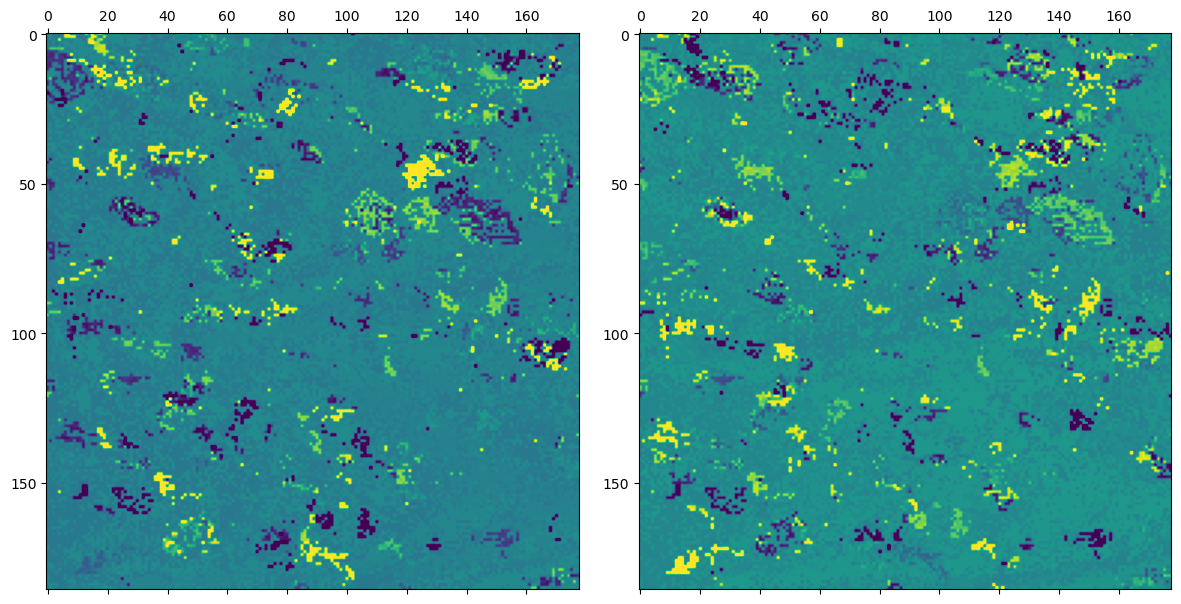

In [48]:
# Measure the origin

qx0_meas,qy0_meas,mask_meas = bragg_peaks.measure_origin()

show(
    [qx0_meas,qy0_meas],
    cmap = 'viridis',
    mask = mask_meas
)

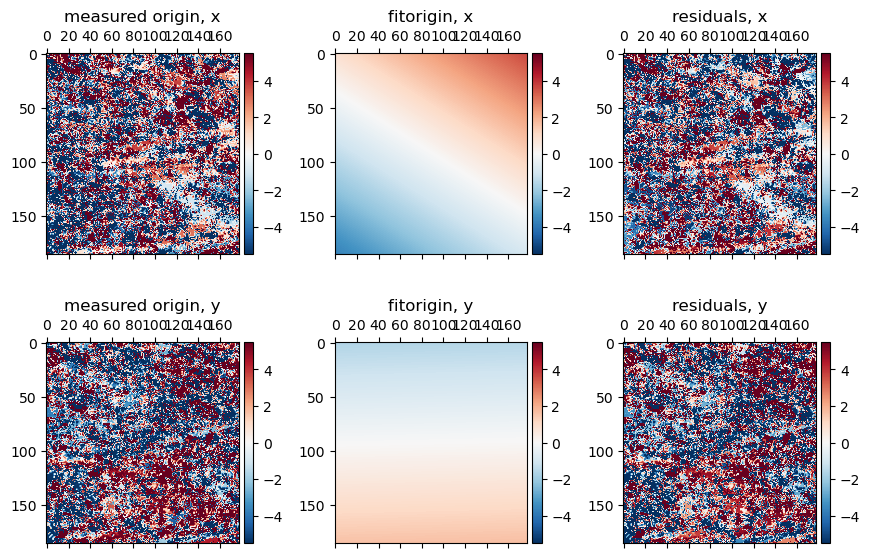

In [49]:
# Fit a plane to the origins

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

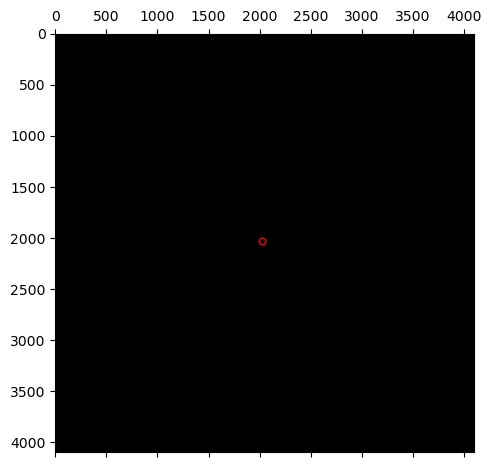

In [51]:
# Now that we've calibrated the center positions, we can re-compute
# the Bragg vector map, this time with the center correction applied

sampling = 8

# compute
bvm = bragg_peaks.histogram(
    #mode='cal',             # 'cal' is the default mode, so this line can be included or left out
    sampling = sampling,
)

# show
# overlay a circle around the center for visualization purposes
show(
    bvm,
    circle={
        'center' : bvm.origin,   # the centered BVM knows where its origin is 
        'R' : 4*sampling,
        'fill' : False,
        'linewidth' : 1
    },
    #vmax=0.9
)

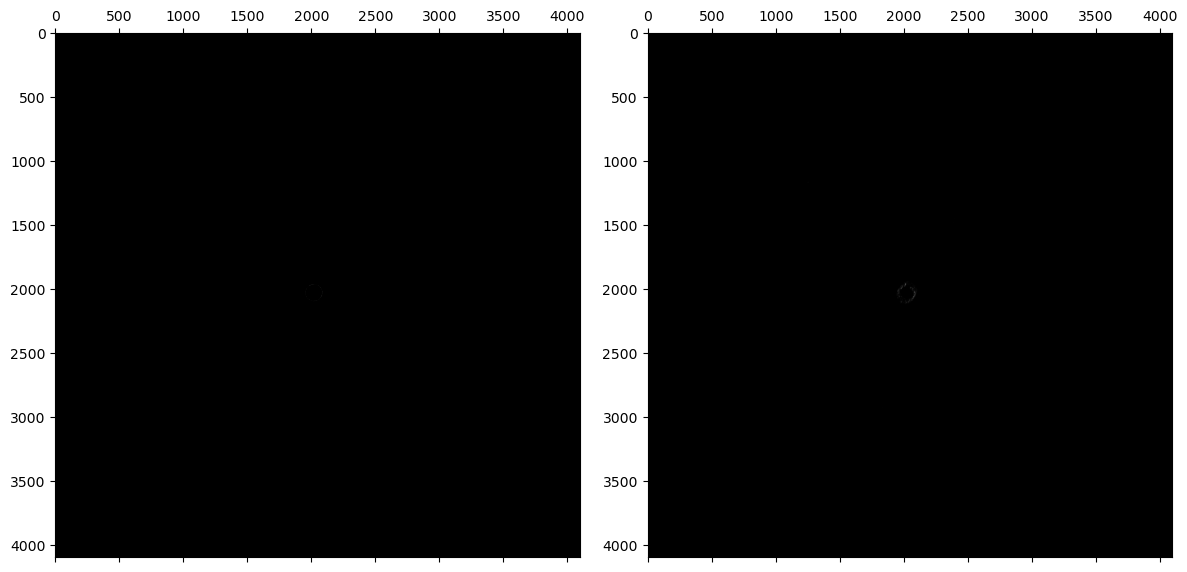

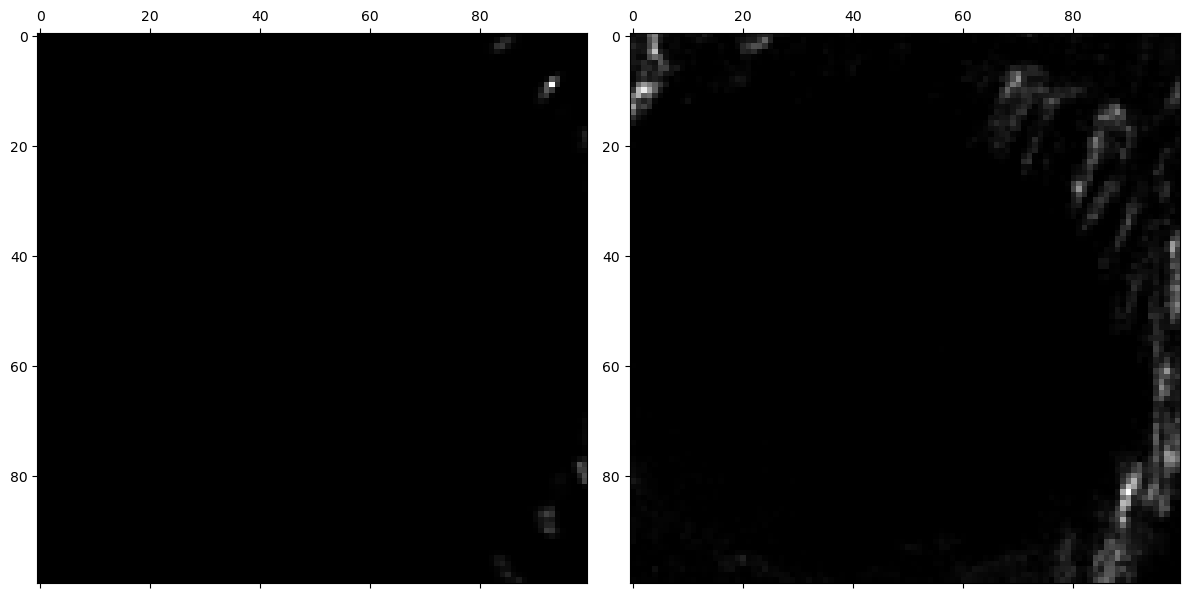

In [29]:
# Compare this to the uncalibrated BVM - much better!

# compute raw vs. centered
bvm_r = bragg_peaks.histogram( mode='raw', sampling=sampling )
bvm_c = bragg_peaks.histogram( mode='cal', sampling=sampling )

# show
show( [bvm_r, bvm_c] ,vmax=1e5)

# show, zooming in on origin
L = 50
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    vmax=1e5
)

## calibrate the ellipticity

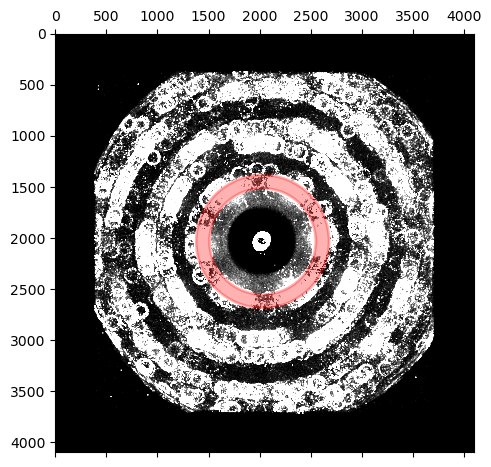

In [53]:
# Select an annular region in which to perform a fit
# The ideal is a single, isolated ring of peaks

q_range = (520, 650)

py4DSTEM.show(
    bvm_c,
    cmap='gray',
    intensity_range='absolute',
    vmin=0,
    vmax=1e2,
    annulus={
        'center':bvm_c.origin,
        'radii': q_range,'fill':True,'color':'r','alpha':0.3}
)

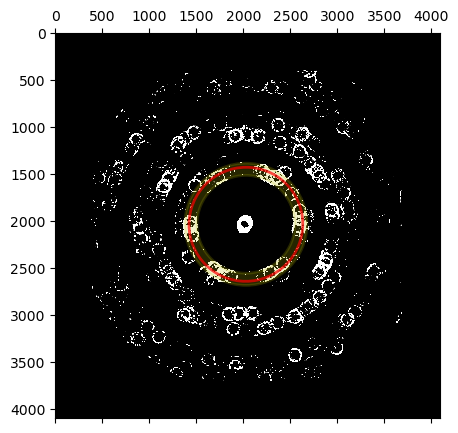

In [54]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_c,
    center = bvm_c.origin,
    fitradii = q_range,
)

# plot the fit
py4DSTEM.visualize.show_elliptical_fit(
    bvm_c,
    q_range,
    p_ellipse,
    cmap='gray',
    intensity_range='absolute',
    vmin=800,
    vmax=1e3,
)

In [55]:
p_ellipse

(2033.1526050010891,
 2028.087312402776,
 607.4964381798316,
 604.1701101346123,
 -0.587707680647599)

In [56]:
# The elliptical parameters are not automatically added to the calibration metadata,
# (to allow inspection of the fit to ensure it's accurate), so need to be added manually
# once a good fit is found. Like so:

bragg_peaks.calibration.set_p_ellipse(p_ellipse)

In [57]:
# Note that the code above only adds (a,b,theta) to the calibration metadata; the origin needs to
# be calibrated separately, as we did above 

bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.02685566
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_mean:           254.17369709345004
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           253.67134323278796
             qy0_shift:          2D-array
             a:                  607.4964381798316
             b:                  604.1701101346123
             theta:              -0.587707680647599
)

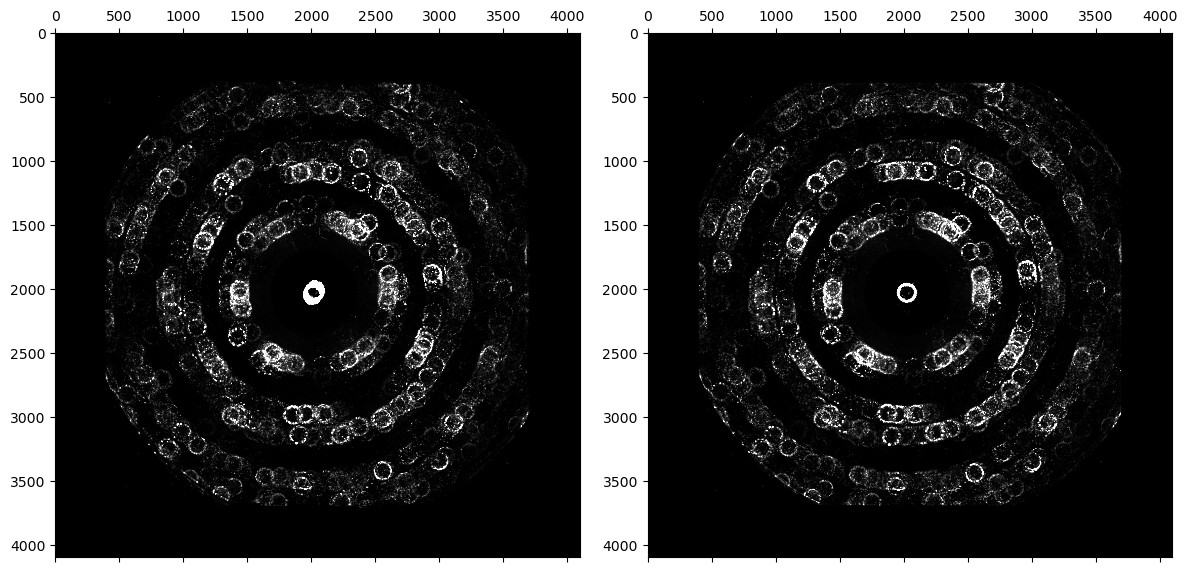

In [58]:
# Calibrate, compute a new bragg vector map, and compare

bragg_peaks.setcal()
bvm_e = bragg_peaks.histogram(
    sampling=sampling
)

show([bvm_e, bvm_r],vmax=0.99)

# Calibrate the detector pixel size

In [59]:
import numpy as np
from py4DSTEM.process.diffraction import Crystal

# Define lattice parameter, atomic numbers, and k_max for structure factor calculation
a_lat = 3.55  # approximate lattice parameter for Cu-Ni alloy in angstroms
atom_num = 29  # atomic numbers for Cu (29) and Ni (28)
k_max = 2  # maximum k value for structure factor calculation

# Example: Alternating Cu and Ni in FCC positions
pos = np.array([
    [0.0, 0.0, 0.0],  # Cu
    [0.0, 0.5, 0.5],  # Ni
    [0.5, 0.0, 0.5],  # Cu
    [0.5, 0.5, 0.0],  # Ni
])

# Make crystal
crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    a_lat)
# Calculate structure factors
crystal.calculate_structure_factors(k_max)



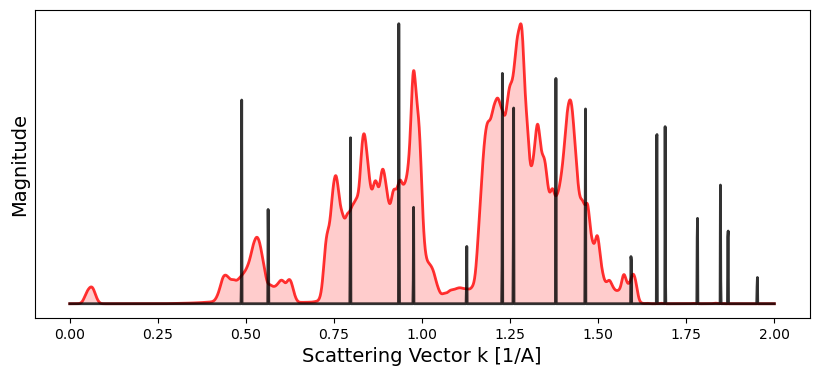

In [67]:
# Make an initial guess at the pixel size to refine
# Let's estimate eith an overlay of the measured scattering and reference crystal structure.


# Modify `pixel_size_inv_Ang_guess` until it 
# looks close before attempting to fit the data!
pixel_size_inv_Ang_guess = 0.00670622


# calibrate
bragg_peaks.calibration.set_Q_pixel_size(pixel_size_inv_Ang_guess)
bragg_peaks.calibration.set_Q_pixel_units('A^-1')
bragg_peaks.setcal()

# show overlay
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks,
    bragg_k_power = 2.0
)

Calibrated pixel size = 0.00670976 A^-1


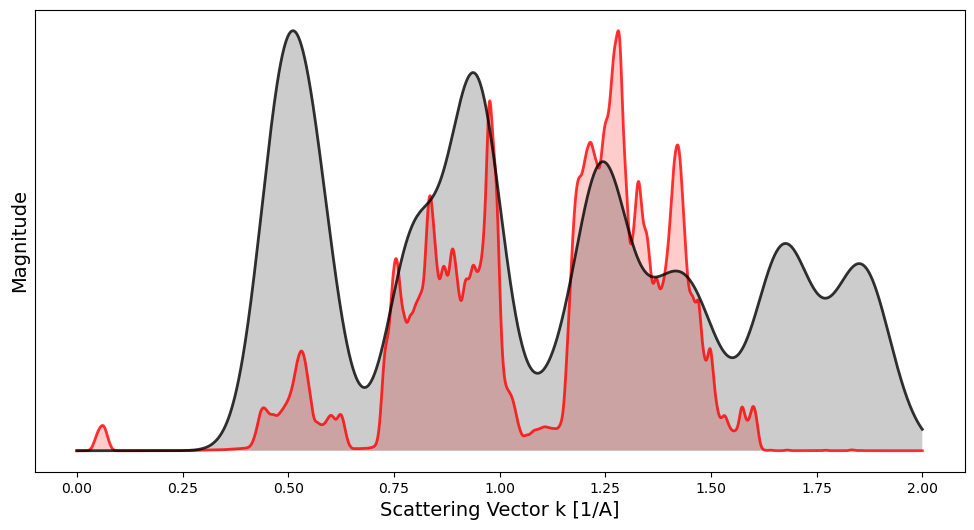

In [68]:
# fit pixel size to lattice

crystal.calibrate_pixel_size(
    bragg_peaks = bragg_peaks,
    bragg_k_power = 2.0,
    plot_result = True,
);

In [69]:
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.00670622
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_mean:           254.17369709345004
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           253.67134323278796
             qy0_shift:          2D-array
             a:                  607.4964381798316
             b:                  604.1701101346123
             theta:              -0.587707680647599
)

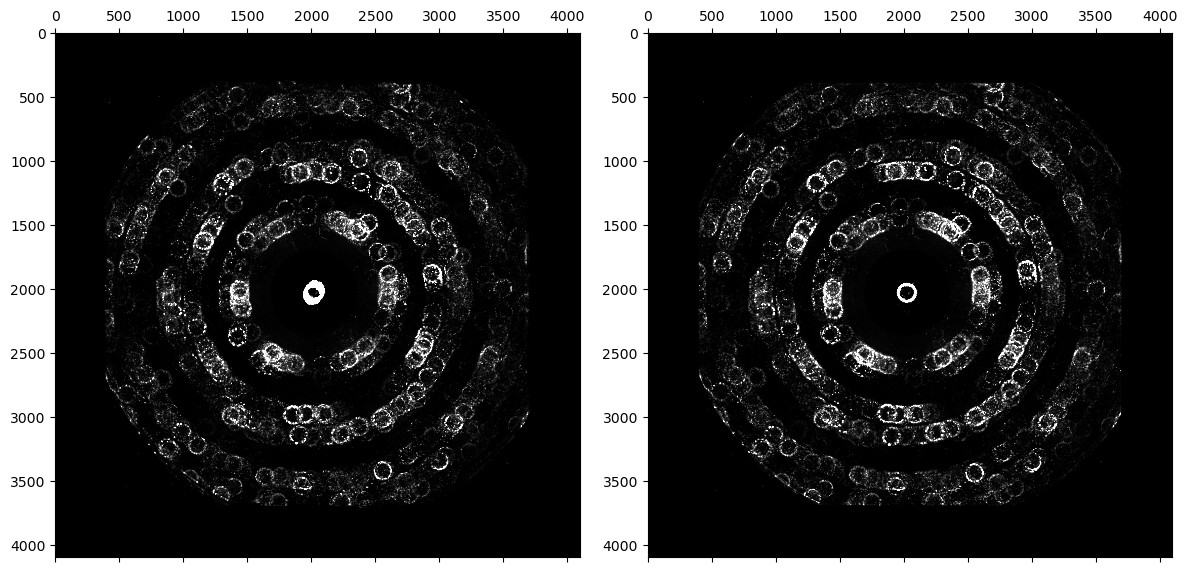

In [70]:
# New bvm, compare

bragg_peaks.setcal()
bvm_p = bragg_peaks.histogram(
    sampling=sampling
)

show([bvm_p, bvm_r],vmax=0.99)

In [72]:
bvm_p

BraggVectorMap( A 2-dimensional array of shape (4096, 4096) called '2Dhist_braggvectors_cal_s=8',
                with dimensions:

                    dim0 = [-1.7045447309220365,-1.7037064534220365,-1.7028681759220365,...] A^-1  (*non-linear*)
                    dim1 = [-1.7011758354145872,-1.7003375579145872,-1.6994992804145872,...] A^-1  (*non-linear*)
)

## calibrate the rotation

In [73]:
QR_rotation = 0

In [74]:
# Set the rotation

bragg_peaks.calibration.set_QR_rotation_degrees( QR_rotation )
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          0.00670622
             R_pixel_size:          5
             Q_pixel_units:         A^-1
             R_pixel_units:         nm
             QR_flip:               False
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             origin_meas_mask:      2D-array
             qx0:                   2D-array
             qx0_mean:              254.17369709345004
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_mean:              253.67134323278796
             qy0_shift:             2D-array
             a:                     607.4964381798316
             b:                     604.1701101346123
             theta:                 -0.587707680647599
             QR_rotation:           0.0
             QR_rotation_degrees:   0
)

# Strain mapping

In [75]:
strainmap = py4DSTEM.StrainMap( braggvectors=bragg_peaks )

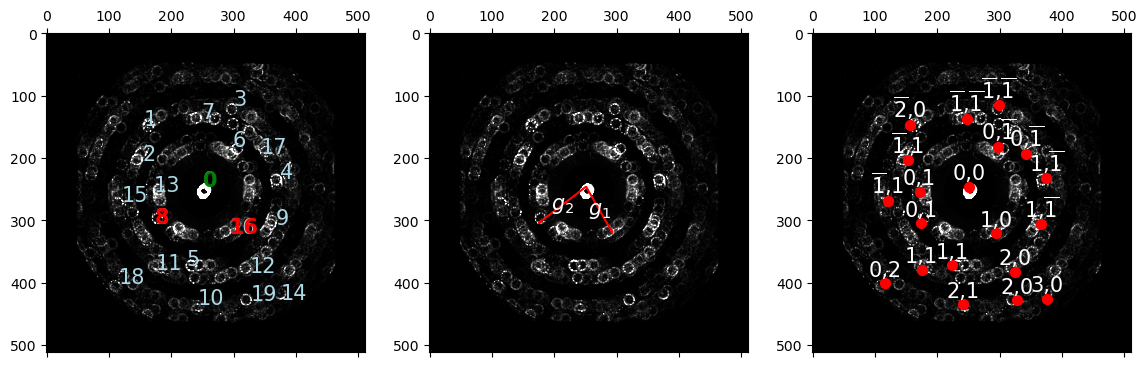

In [120]:
strainmap.choose_basis_vectors(
    minSpacing=40,
    minAbsoluteIntensity=3e3,
    maxNumPeaks=20,
    edgeBoundary=40,
    vis_params = {
        'vmin' : 0,
        'vmax' : 0.995
    }
)

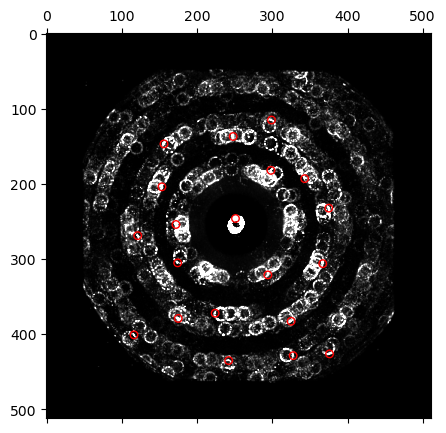

In [121]:
strainmap.set_max_peak_spacing(
    max_peak_spacing = 5
)

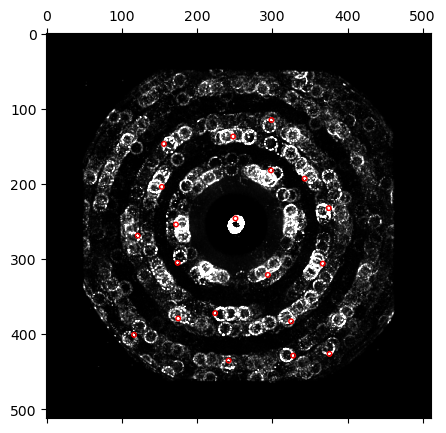

Indexing Bragg scattering: 100%|███████████████████████████████████████████████████████| 33.1k/33.1k [00:08<00:00, 3.97kDP/s]
Fitting lattice vectors: 100%|█████████████████████████████████████████████████████████| 33.1k/33.1k [00:00<00:00, 64.3kDP/s]


In [122]:
strainmap.fit_basis_vectors(
    max_peak_spacing = 3
)

Calculating strain: 100%|██████████████████████████████████████████████████████████████| 33.1k/33.1k [00:06<00:00, 4.77kDP/s]


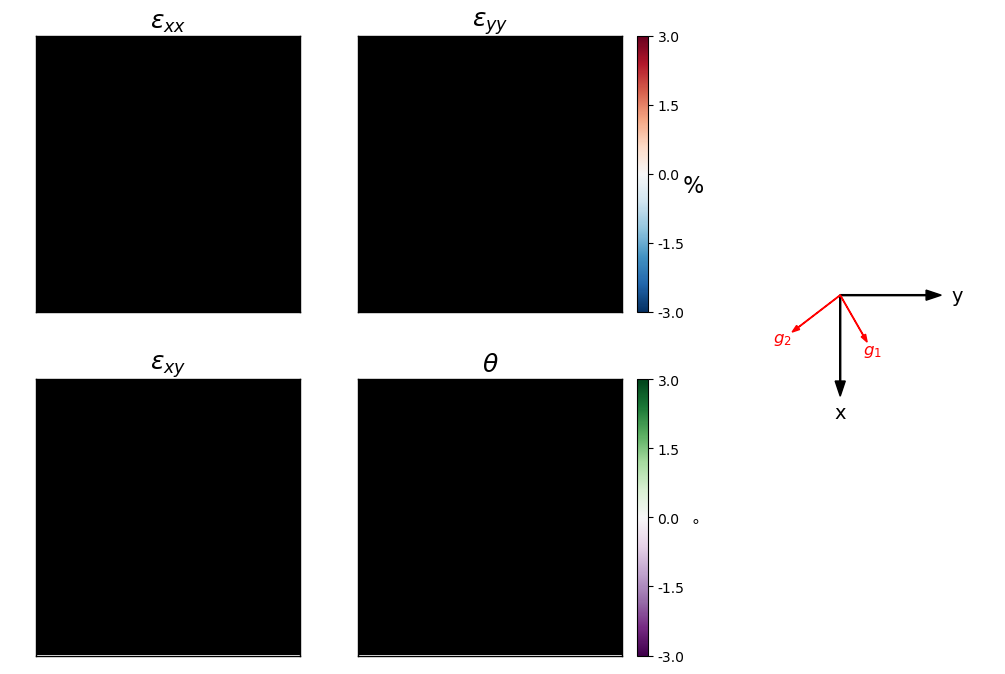

In [123]:
# strain map

strainmap.get_strain(
    gvects=None,
    coordinate_rotation=0,
    returncalc=False,
)

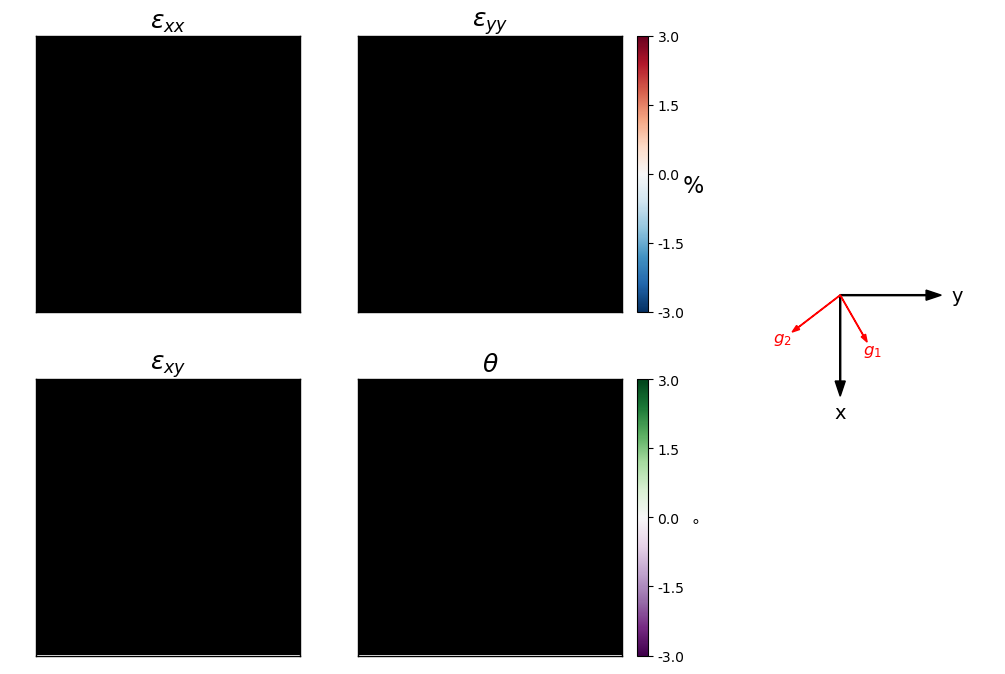

In [124]:
strainmap.show_strain(
    vrange=[-3, 3],
    vrange_theta=[-3, 3],
    vrange_exx=None,
    vrange_exy=None,
    vrange_eyy=None,
    show_cbars=None,
    bordercolor='k',
    borderwidth=1,
    titlesize=18,
    ticklabelsize=10,
    ticknumber=5,
    unitlabelsize=16,
    cmap='RdBu_r',
    cmap_theta='PRGn',
    mask_color='k',
    color_axes='k',
    show_legend=True,
    show_gvects=True,
    color_gvects='r',
    legend_camera_length=1.6,
    scale_gvects=0.6,
    layout='square',
    figsize=None,
    returnfig=False,
)

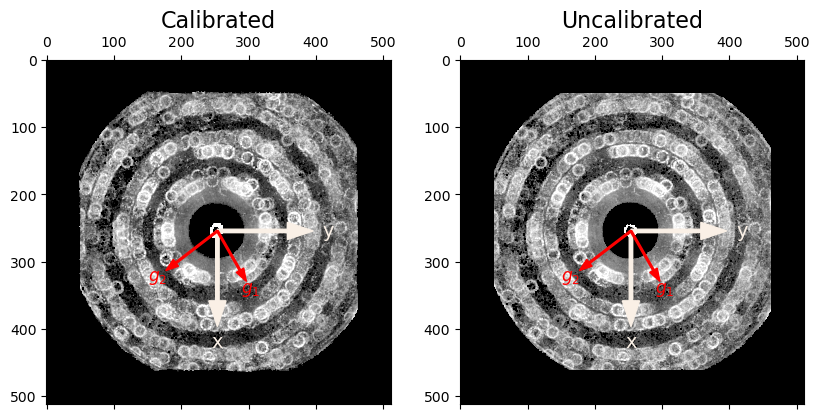

In [125]:
strainmap.show_reference_directions(
    im_uncal=None,
    im_cal=None,
    color_axes='linen',
    color_gvects='r',
    origin_uncal=None,
    origin_cal=None,
    camera_length=1.8,
    visp_uncal={'scaling': 'log'},
    visp_cal={'scaling': 'log'},
    layout='horizontal',
    titlesize=16,
    size_labels=14,
    figsize=None,
    returnfig=False,
)

# Pixel size calibration

In [126]:
#Load the cif crystal file
from py4DSTEM import Crystal

crystal = py4DSTEM.process.diffraction.Crystal.from_CIF(filepath_cif)
print(crystal.lat_real)

# Calculate structure factors
structure_factors, intensities = crystal.calculate_structure_factors(
    k_max=k_max,
    return_intensities=True
)

# Print the results
print("Structure Factors:", structure_factors)
print("Intensities:", intensities)


[[3.56150000e+00 0.00000000e+00 0.00000000e+00]
 [2.18078979e-16 3.56150000e+00 0.00000000e+00]
 [2.18078979e-16 2.18078979e-16 3.56150000e+00]]
Structure Factors: [0.         0.0060241  0.01204819 0.01807229 0.02409639 0.03012048
 0.03614458 0.04216867 0.04819277 0.05421687 0.06024096 0.06626506
 0.07228916 0.07831325 0.08433735 0.09036145 0.09638554 0.10240964
 0.10843373 0.11445783 0.12048193 0.12650602 0.13253012 0.13855422
 0.14457831 0.15060241 0.15662651 0.1626506  0.1686747  0.1746988
 0.18072289 0.18674699 0.19277108 0.19879518 0.20481928 0.21084337
 0.21686747 0.22289157 0.22891566 0.23493976 0.24096386 0.24698795
 0.25301205 0.25903614 0.26506024 0.27108434 0.27710843 0.28313253
 0.28915663 0.29518072 0.30120482 0.30722892 0.31325301 0.31927711
 0.3253012  0.3313253  0.3373494  0.34337349 0.34939759 0.35542169
 0.36144578 0.36746988 0.37349398 0.37951807 0.38554217 0.39156627
 0.39759036 0.40361446 0.40963855 0.41566265 0.42168675 0.42771084
 0.43373494 0.43975904 0.44578313

get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().


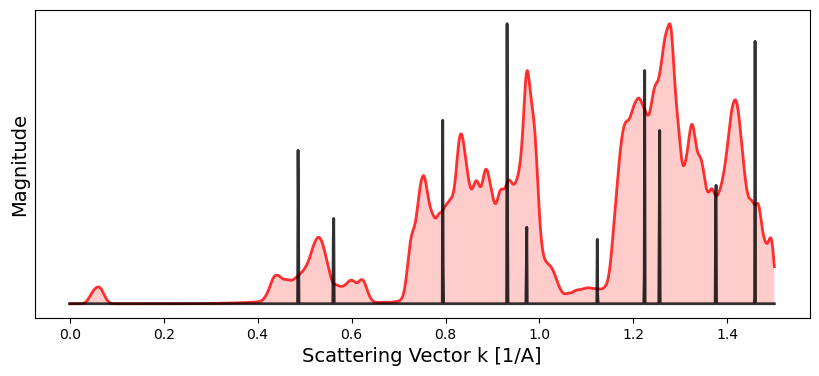

In [127]:
# Compare measured diffraction pattern with reference crystal structure
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks,
    bragg_k_power = 2.0,
)

   Initial pixel size = 0.00668933 A^-1
Calibrated pixel size = 0.00666198 A^-1


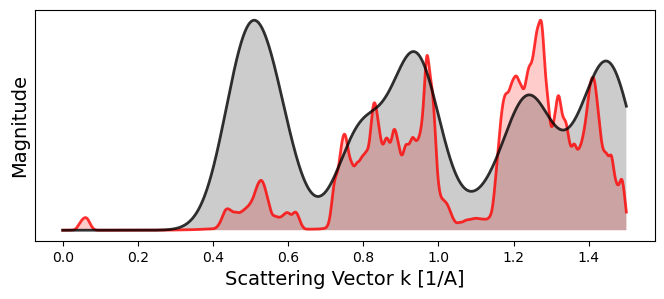

In [128]:
# Display the current pixel size
print('   Initial pixel size = ' + \
    str(np.round(bragg_peaks.calibration.get_Q_pixel_size(),8)) + \
    ' ' + bragg_peaks.calibration.get_Q_pixel_units())

# Calibrate pixel size
bragg_peaks_cali = crystal.calibrate_pixel_size(
    bragg_peaks = bragg_peaks,
    bragg_k_power = 2.0,
    plot_result = True,
    figsize = (8,3),
)

In [129]:
# Save calibrated Bragg peaks
filepath_braggdisks_cal = dirpath + 'braggdisks_cal_ROI3.h5'

py4DSTEM.save(
    filepath_braggdisks_cal,
    bragg_peaks_cali,
    mode='o',
)

100%|████████████████████████████████████████████████████████████████████████████████| 33108/33108 [00:03<00:00, 8967.78it/s]


# Automated crystal orientation mapping (ACOM)

In [95]:
# Reload Bragg peaks if needed
#filepath_braggdisks_cal = dirpath + 'braggdisks_cal_V2.h5'
#py4DSTEM.print_h5_tree(filepath_braggdisks_cal)

In [130]:
# Reload bragg peaks cif file, recompute structure factors
bragg_peaks = py4DSTEM.read(
    filepath_braggdisks_cal, 
)
bragg_peaks

k_max = 1.4
crystal = py4DSTEM.process.diffraction.Crystal.from_CIF(filepath_cif)
crystal.calculate_structure_factors(
    k_max,
)


Reading PointListArray: 100%|█████████████████████████████████████████████████| 33108/33108 [00:05<00:00, 6452.96PointList/s]
get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().


In [131]:
# Create an orientation plan for [001] 
crystal.orientation_plan(
    angle_step_zone_axis = 1.0,
    angle_step_in_plane = 4.0,
    zone_axis_range = 'fiber',
    fiber_axis = [0,0,1],
    fiber_angles = [0,0],
#     CUDA=True,
)

Orientation plan: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1504.41 zone axes/s]


Best fit lattice directions: z axis = ([ 0.  0. -1.]), x axis = ([ 0.789 -0.     0.614]), with corr value = 4.613


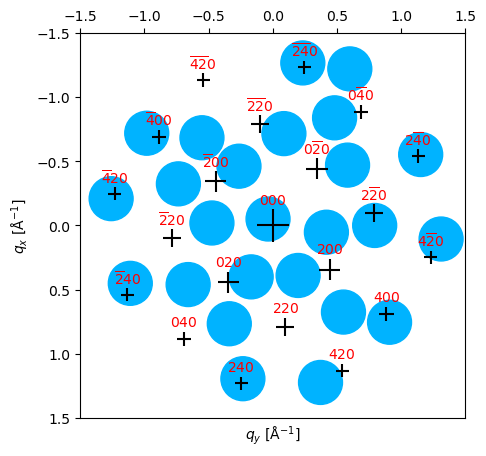

In [132]:
import numpy as np

# Test matching on some probe positions
xind, yind = 20,64
#xind, yind= 33,25

orientation  = crystal.match_single_pattern(
    bragg_peaks.cal[xind,yind],
#     plot_corr = True,
#     plot_polar = False,
    verbose = True,
)

sigma_compare = 0.03
range_plot = np.array([k_max+0.1,k_max+0.1])

bragg_peaks_fit = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)


# plot comparisons
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks.cal[xind,yind],
    scale_markers=1000,
    scale_markers_compare=4e4,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize = (5,5),
)

In [133]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks,
)

Matching Orientations: 100%|█████████████████████████████████████████████████| 33108/33108 [00:25<00:00, 1321.04 PointList/s]


In [134]:
orientation_map.angles[0:2,0:2,0,2]

array([[4.11995104, 7.26511024],
       [7.91718622, 4.11101742]])

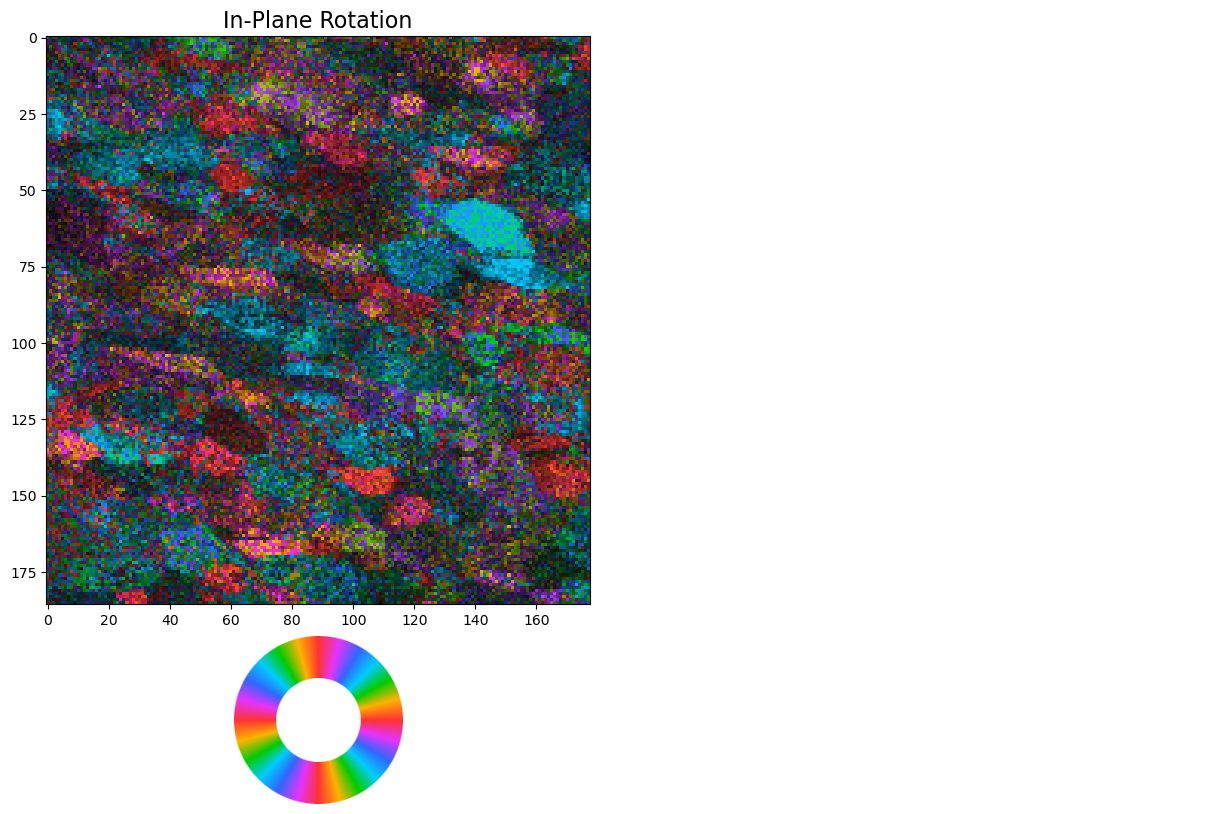

In [195]:
# Plot the orienations 
images_orientation = crystal.plot_fiber_orientation_maps(
    orientation_map,
    symmetry_order = 4,
    corr_range = [0,2], #Correlation intensity range for the plot
    dir_in_plane_degrees = 0.0, #Reference in-plane angle (degrees). Default is 0 / x-axis / vertical down.
    corr_normalize = True, # If true, set mean correlation to 1.
    cmap_out_of_plane= 'plasma', 
    figsize = (12, 8),
)

# In/Out of plane orientation mapping

In [105]:
# Reload Bragg peaks if needed
#filepath_braggdisks_cal = dirpath + 'braggdisks_cal_V2.h5'
#py4DSTEM.print_h5_tree(filepath_braggdisks_cal)

In [106]:

# Example: Alternating Cu and Ni in FCC positions
pos = np.array([
    [0.0, 0.0, 0.0],  # Cu
    [0.0, 0.5, 0.5],  # Ni
    [0.5, 0.0, 0.5],  # Cu
    [0.5, 0.5, 0.0],  # Ni
])

atom_num = 29
a = 3.55
cell = a

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)


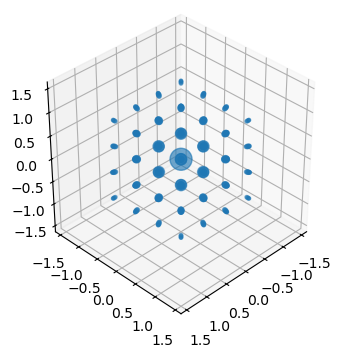

In [107]:
# Calculate and plot structure factors
k_max = 1.5

crystal.calculate_structure_factors(
    k_max,
)

crystal.plot_structure_factors(
    zone_axis_lattice=[1,1,1],
    figsize = (4,4),
)

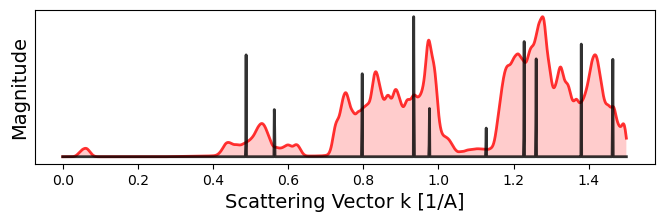

In [108]:
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_cali,
    bragg_k_power = 2.0,
    figsize = (8,2),
)

100%|███████████████████████████████████████████████████████████████████████████████| 33108/33108 [00:02<00:00, 12256.91it/s]


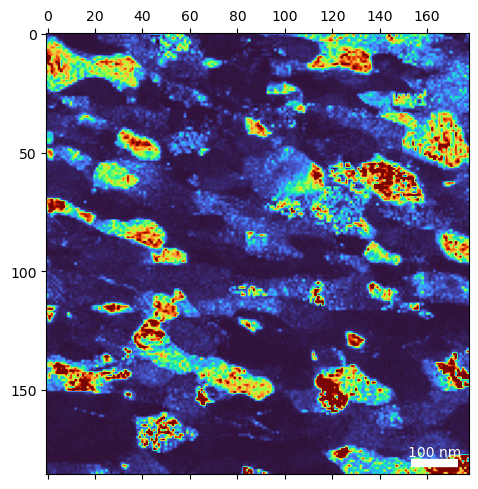

In [109]:
# Make and plot a virtual dark field image to find the non-vacuum probe positions
im_DF = bragg_peaks_cali.get_virtual_image(
    mode = 'annular',
    geometry=((),(0.3,0.6)),
)

py4DSTEM.show(
    im_DF,
    cmap='turbo',
)

In [110]:
# # Create an orientation plan using pymatgen

crystal.orientation_plan(
    zone_axis_range = 'auto',
    angle_step_zone_axis = 2.0,
    #
    # angle_step_zone_axis = 0.5,
    # angle_coarse_zone_axis = 2.0,
    # angle_refine_range = 2.0,
    #
    angle_step_in_plane = 5.0,
    accel_voltage = 200e3,
#     CUDA = True,
#     intensity_power = 0.5,
#     intensity_power = 0.125,
#     radial_power = 2.0,
    # corr_kernel_size = 0.12,
    # tol_peak_delete = 0.08,
)

Automatically detected point group m-3m,
 using arguments: zone_axis_range = 
[[0 1 1]
 [1 1 1]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 2615.26 zone axes/s]


In [111]:
import matplotlib.pyplot as plt

Best fit lattice directions: z axis = ([0.049 0.28  0.959]), x axis = ([0.076 0.084 0.994]), with corr value = 5.756
Best fit lattice directions: z axis = ([0.447 0.587 0.675]), x axis = ([0.232 0.653 0.721]), with corr value = 4.682
Best fit lattice directions: z axis = ([0.217 0.418 0.882]), x axis = ([0.032 0.253 0.967]), with corr value = 3.822


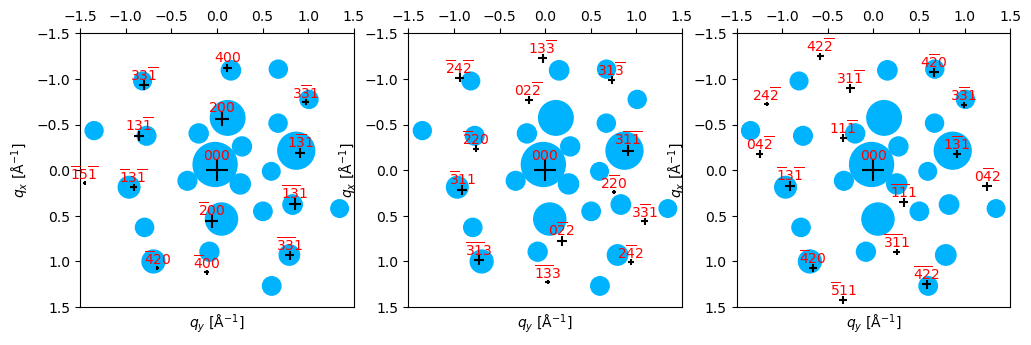

In [112]:
# Test matching on some probe positions
sigma_compare = 0.03  # Excitation error for the simulated diffraction patterns
figsize = (12,4)

xind, yind = 34, 12
xind, yind = 40, 93
# xind, yind = 30, 40

# plotting parameters
plot_params = {
    'scale_markers': 500,
    'scale_markers_compare': 10,
    'plot_range_kx_ky': crystal.k_max,
    'min_marker_size': 2,
}

# Find best fit orientations
orientation  = crystal.match_single_pattern(
    bragg_peaks_cali.cal[xind,yind],
    num_matches_return = 3,
    verbose = True,
)

# Simulated bragg peaks from best fit orientations
peaks_fit_0 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)
peaks_fit_1 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=1,
    sigma_excitation_error=sigma_compare)
peaks_fit_2 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=2,
    sigma_excitation_error=sigma_compare)

# plot comparisons
fig,ax = plt.subplots(1,3,figsize=figsize)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    peaks_fit_0,
    bragg_peaks_compare=bragg_peaks_cali.cal[xind,yind],
    **plot_params,
    input_fig_handle=(fig,[ax[0]]),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    peaks_fit_1,
    bragg_peaks_compare=bragg_peaks_cali.cal[xind,yind],
    **plot_params,
    input_fig_handle=(fig,[ax[1]]),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    peaks_fit_2,
    bragg_peaks_compare=bragg_peaks_cali.cal[xind,yind],
    **plot_params,
    input_fig_handle=(fig,[ax[2]]),
)

In [113]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks_cali,
    num_matches_return = 1,
    min_number_peaks = 3,
)

Matching Orientations: 100%|███████████████████████████████████████████████████| 33108/33108 [06:07<00:00, 90.19 PointList/s]


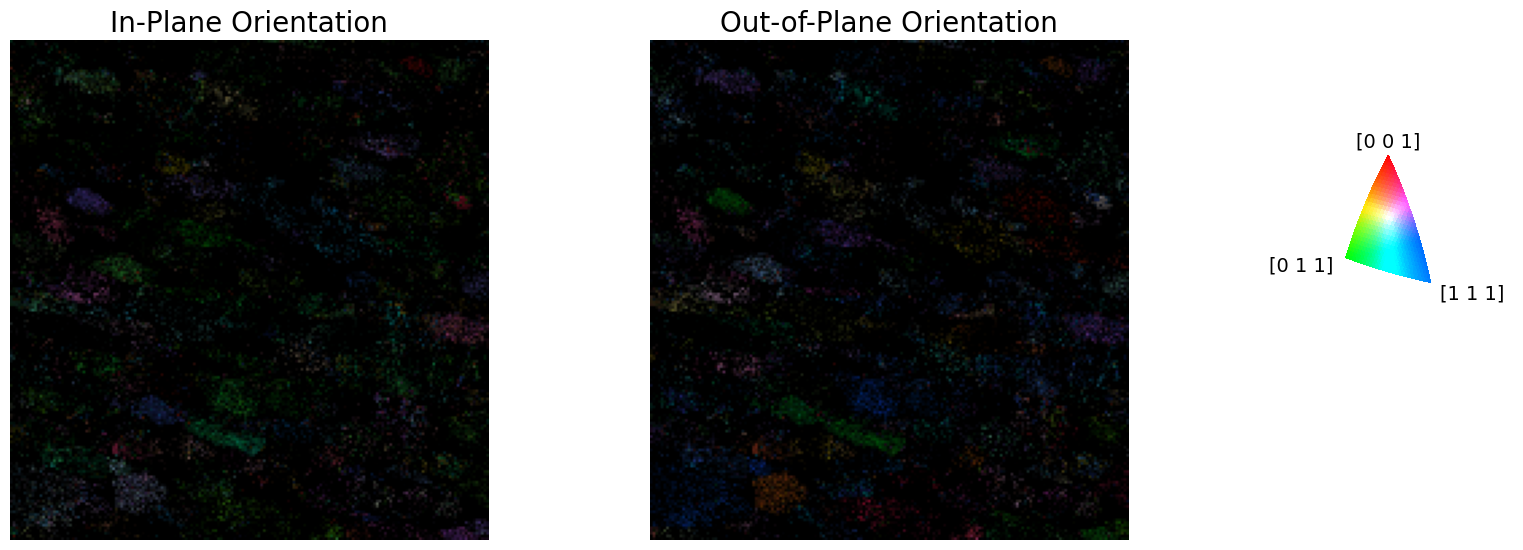

In [114]:
# plot orientation map
images_orientation = crystal.plot_orientation_maps(
    orientation_map,
    orientation_ind=0,
    corr_range = np.array([1,4]),
    camera_dist = 10,
    show_axes = False,
)

In [136]:
# set a filepath

ACOM_ROI3 = dirpath + 'ACOM_HPT_ROI3.h5'

ACOM_ROI3

'/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/ACOM_HPT_ROI3.h5'

In [144]:
# inspect what's in the data tree

datacube.tree()

/
|---bright_field
|---braggvectors
|   |---strainmap
|---2Dhist_braggvectors_cal_s=8


In [146]:
# save
py4DSTEM.save(
    ACOM_ROI3,
    datacube,
    tree=None,
    mode = 'o'
)

100%|████████████████████████████████████████████████████████████████████████████████| 33108/33108 [00:03<00:00, 8814.96it/s]


In [148]:
# inspect the resulting HDF5 file

py4DSTEM.print_h5_tree(ACOM_ROI3)

/
|---dm_dataset_root
    |---2Dhist_braggvectors_cal_s=8
    |---braggvectors
    |   |---_v_uncal
    |   |---strainmap
    |---bright_field


